# OutliersDetection

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict

#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler # To transform the dataset
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import kmeans_plusplus
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm

In [3]:
X_train = pd.read_csv("/Users/salvu/Desktop/DM2Git/1Modulo/X_train.txt", header=None,  delim_whitespace=True)
y_train = pd.read_csv("/Users/salvu/Desktop/DM2Git/1Modulo/y_train.txt", header=None, delim_whitespace=True )
X_test = pd.read_csv("/Users/salvu/Desktop/DM2Git/1Modulo/X_test.txt", header=None, delim_whitespace=True )
y_test = pd.read_csv("/Users/salvu/Desktop/DM2Git/1Modulo/y_test.txt", header=None, delim_whitespace=True )
features = pd.read_csv("/Users/salvu/Desktop/DM2Git/1Modulo/features.txt", header=None, delim_whitespace=True )
subject = pd.read_csv("/Users/salvu/Desktop/DM2Git/1Modulo/subject_train.txt", header=None, delim_whitespace=True )

In [4]:
feature = features
subjects = subject
feature.drop(0,inplace=True, axis=1)

In [5]:
#inseriamo l'intestazione al dataset
lista=[]
feat_transpa = feature.transpose()
for i in range(561):
    lista.append(feat_transpa.iloc[0][i])
X_test.columns=lista    
X_train.columns=lista

In [6]:
# eliminiamo le colonne che contengono la stima mad in quanto quasi uguale a dev.std
stringa="mad()"
for col in X_train.columns:
    if(stringa in col):
        X_train.drop(labels=col, axis=1, inplace=True)
for col in X_test.columns:
    if(stringa in col):
        X_test.drop(labels=col, axis=1, inplace=True)        

## LOF

In [7]:
from sklearn.neighbors import LocalOutlierFactor
from numpy import quantile, random, where

In [8]:
lof = LocalOutlierFactor(n_neighbors=25)
outliers = lof.fit_predict(X_train)
lofs_index = where(outliers==-1)

In [9]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  11, 7341], dtype=int64))

In [10]:
outliers_score = lof.negative_outlier_factor_
outliers_score

array([-1.52784477, -1.05041742, -1.01806226, ..., -1.02954003,
       -1.02224792, -1.00586738])

In [11]:
outlier4 = np.where(outliers==-1)

In [12]:
#Creo dataset per inserire outlier di una serie di metodi
X = pd.DataFrame(outliers_score, columns=["LOF_score"])
X["LOF_label"] = outliers

In [13]:
lof.negative_outlier_factor_[np.where(outliers==-1)]

array([-1.52784477, -1.760977  , -1.72745014, -1.50318232, -1.51039996,
       -1.74512234, -1.56053596, -1.50648009, -1.56032587, -1.77559099,
       -1.66224976])

In [14]:
max_val = np.max(lof.negative_outlier_factor_[np.where(outliers==-1)])
max_val

-1.5031823240441307

In [15]:
np.min(lof.negative_outlier_factor_[np.where(outliers==-1)])

-1.7755909870010032

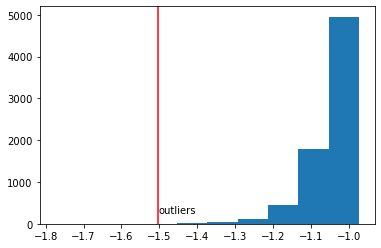

In [16]:
plt.hist(lof.negative_outlier_factor_, bins=10)
plt.axvline(max_val, c='r')
plt.text(max_val, 250, 'outliers')
plt.show()

## Isolation Forest

In [17]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from numpy import quantile, random, where

In [18]:
contamination=float(.01) #specifichiamo la percentuale di outliers che si presume ci sia

In [19]:
%%time
IF = IsolationForest(n_estimators = 100, random_state=42)
IF.fit(X_train)

CPU times: total: 2.41 s
Wall time: 2.41 s


IsolationForest(random_state=42)

In [20]:
outliers = IF.predict(X_train)
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 631, 6721], dtype=int64))

In [21]:
my_array=IF.decision_function(X_train) #score
my_array2=IF.predict(X_train) #label

In [22]:
#creo un dataset in cui vado ad inserire tutte le anomalie con lo score corrispondente
X["IF_score"] = my_array
X["IF_label"] = my_array2

In [23]:
#se vogliamo printare le anomalie o la riga corrispondente
anomaly=X.loc[X['IF_label']==-1]
anomaly_index=list(anomaly.index)

In [24]:
X_train.iloc[anomaly_index]

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
67,-0.239103,-0.096904,0.148035,-0.637325,-0.127692,-0.258924,-0.878149,-0.241482,-0.120985,0.263374,...,-0.691219,-0.157009,-0.561918,0.002418,-0.002366,-0.101878,0.543207,0.378792,-0.488443,-0.487057
69,0.303833,0.103648,-0.245331,-0.755994,-0.642571,-0.695501,-0.717081,-0.182864,-0.560333,0.574444,...,-0.281684,-0.268042,-0.609644,-0.116769,-0.391404,0.413596,0.051020,0.494535,-0.465940,-0.535802
70,-0.361205,-0.268121,0.176896,-0.599392,0.532506,0.004324,-0.717081,-0.182864,0.315453,0.022282,...,-0.525170,0.063364,-0.330520,0.152830,0.149602,0.127245,0.192852,0.508733,-0.496132,-0.506197
71,-0.277066,-0.684097,0.346658,-0.596410,0.024683,-0.160404,-0.866296,-0.249047,0.315453,0.022282,...,-0.533867,0.018979,-0.437059,0.123108,0.432540,-0.083446,0.025648,0.668284,-0.336641,-0.672685
101,0.261081,-0.015636,-0.102588,-0.171239,0.201236,-0.261589,0.022737,-0.104128,-0.167734,0.153242,...,0.238314,0.278557,0.034323,0.717645,0.401581,-0.038345,-0.593632,-0.749963,0.269151,0.043100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6939,0.470751,-0.040032,-0.242380,0.283371,0.230982,-0.269655,0.478404,0.180164,-0.399982,-0.103330,...,0.033439,-0.236577,-0.637228,-0.415789,0.480924,0.992026,0.064899,-0.923119,0.123846,-0.031750
6957,0.217508,-0.074056,-0.212026,-0.029212,-0.039285,0.167732,0.323658,-0.022203,0.027064,0.188471,...,0.078586,-0.731763,-0.956850,0.087289,0.411382,-0.728625,-0.631756,-0.783200,0.247893,0.012588
7304,0.316681,-0.020640,-0.132595,0.245688,0.261090,-0.134618,0.479594,0.311558,-0.004935,-0.245049,...,0.031172,-0.396526,-0.782491,-0.458666,-0.513656,0.877342,0.496022,-0.909396,0.142928,-0.028533
7309,0.207542,-0.048698,-0.053467,0.158584,0.025743,0.130814,0.530997,-0.060730,0.433908,0.053708,...,0.053021,-0.319266,-0.726092,0.310813,-0.863683,-0.553296,-0.373964,-0.930773,0.145327,0.008707


## ABOD

In [26]:
#!pip install pyod
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.loci import LOCI
#from pyod.models.auto_encoder import AutoEncoder

In [27]:
abod = ABOD(n_neighbors=17)
abod.fit(X_train)

ABOD(contamination=0.1, method='fast', n_neighbors=17)

In [28]:
abod_score= abod.decision_scores_

In [29]:
outliers = abod.predict(X_train)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([6623,  729], dtype=int64))

In [30]:
X["ABOD_score"] = abod_score
X["ABOD_label"] = outliers

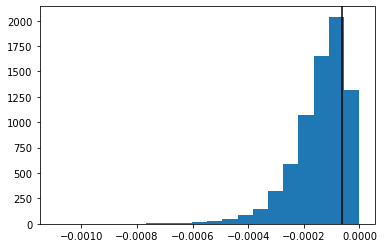

In [31]:
plt.hist(abod.decision_scores_, bins=20)
plt.axvline(np.min(abod.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

## KNN

## Find best K

Minimum error:- 0.09263657957244656 at K = 17


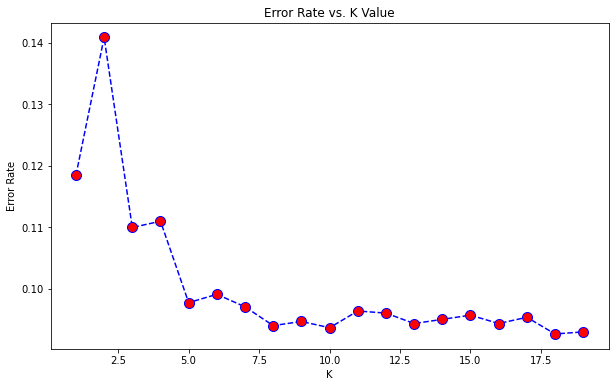

In [32]:
from sklearn.neighbors import KNeighborsClassifier

error_rate = []
for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train.values.ravel())
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != np.ravel(y_test)))
#print(pred_i)
plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [33]:
clf = KNN(n_neighbors=17, metric='euclidean')
clf.fit(X_train)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='euclidean', metric_params=None, n_jobs=1, n_neighbors=17, p=2,
  radius=1.0)

In [34]:
outliers = clf.predict(X_train)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([6641,  711], dtype=int64))

In [35]:
anomlay_score = clf.decision_function(X_train)

In [36]:
X["KNN_score"]= anomlay_score
X["KNN_label"] = outliers

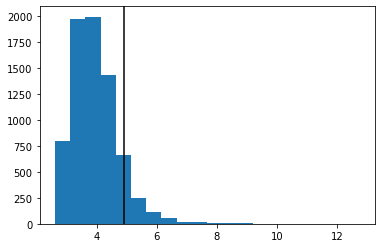

In [37]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

## Dataset completo degli outliers


In [38]:
#Impostiamo un unica label di -1 outlier e 1 inlier
classe = { 1 : -1 , 0 : 1}
X["ABOD_label"] = X["ABOD_label"].map(classe)
X["KNN_label"] = X["KNN_label"].map(classe)

In [39]:
X

,LOF_score,LOF_label,IF_score,IF_label,ABOD_score,ABOD_label,KNN_score,KNN_label
0,-1.527845,-1,0.092852,1,-0.000027,-1,5.159969,-1
1,-1.050417,1,0.126769,1,-0.000137,1,3.275084,1
2,-1.018062,1,0.136065,1,-0.000147,1,3.063645,1
3,-1.132522,1,0.132719,1,-0.000091,1,3.516144,1
4,-1.021091,1,0.129952,1,-0.000220,1,3.022345,1
...,...,...,...,...,...,...,...,...
7347,-1.009131,1,0.056133,1,-0.000090,1,4.010685,1
7348,-1.013739,1,0.057693,1,-0.000066,1,4.078017,1
7349,-1.029540,1,0.059363,1,-0.000078,1,4.226437,1
7350,-1.022248,1,0.058541,1,-0.000083,1,4.145599,1


## TOP 10 outliers KNN vs Rest

In [40]:
#KNN
a=X["KNN_score"].tolist()
a.sort(reverse=True)
#a

In [41]:
b=[]   #lista in cui salvo la top 1% di outlier
k=0
for i in a:
    b.append(i)
    k+=1
    if(k==10):
        break
#b  #top 10     

In [42]:
indx1=[]
for i in range(len(X)):
    for j in b:
        if(j==X.iloc[i]["KNN_score"]):
            indx1.append(i)
indx1

[71, 2451, 3928, 3929, 3930, 3934, 3935, 3936, 3939, 5137]

In [43]:
X.iloc[indx1].sort_values(by=['KNN_score'],  ascending=False).round(6)    #+ alto è lo score + "outlier" è

,LOF_score,LOF_label,IF_score,IF_label,ABOD_score,ABOD_label,KNN_score,KNN_label
3934,-1.560536,-1,-0.208616,-1,-0.000001,-1,12.572690,-1
3935,-1.506480,-1,-0.218551,-1,-0.000003,-1,12.161422,-1
3939,-1.293452,1,-0.195992,-1,-0.000002,-1,10.001526,-1
2451,-1.409836,1,-0.083054,-1,-0.000002,-1,9.124005,-1
3930,-1.174960,1,-0.181542,-1,-0.000006,-1,8.954388,-1
3936,-1.199132,1,-0.180224,-1,-0.000015,-1,8.926559,-1
3928,-1.179234,1,-0.175784,-1,-0.000008,-1,8.613913,-1
3929,-1.156016,1,-0.178429,-1,-0.000008,-1,8.606475,-1
5137,-1.246654,1,-0.057377,-1,-0.000006,-1,8.526588,-1
71,-1.727450,-1,-0.074080,-1,-0.000006,-1,8.481428,-1


## TOP 10 outliers ABOD vs Rest

In [44]:
a=X["ABOD_score"].tolist()
a.sort(reverse=True)
#a

In [45]:
b=[]
k=0
for i in a:
    b.append(i)
    k+=1
    if(k==10):
        break
#b  #top 10     

In [46]:
indx2=[]
for i in range(len(X)):
    for j in b:
        if(j==X.iloc[i]["ABOD_score"]):
            indx2.append(i)
indx2

[238, 1271, 2451, 2532, 2937, 3934, 3935, 3939, 4828, 5020]

In [47]:
X.iloc[indx2].sort_values(by=['ABOD_score'],  ascending=False).round(6)   #+ piccolo è lo score + "outlier" è

,LOF_score,LOF_label,IF_score,IF_label,ABOD_score,ABOD_label,KNN_score,KNN_label
3934,-1.560536,-1,-0.208616,-1,-0.000001,-1,12.572690,-1
3939,-1.293452,1,-0.195992,-1,-0.000002,-1,10.001526,-1
2451,-1.409836,1,-0.083054,-1,-0.000002,-1,9.124005,-1
1271,-1.165941,1,-0.163395,-1,-0.000002,-1,7.752428,-1
3935,-1.506480,-1,-0.218551,-1,-0.000003,-1,12.161422,-1
4828,-1.291587,1,-0.140183,-1,-0.000003,-1,7.930229,-1
2532,-1.475940,1,-0.109550,-1,-0.000003,-1,7.177296,-1
2937,-1.436136,1,-0.001964,-1,-0.000004,-1,6.141292,-1
238,-1.453053,1,-0.033280,-1,-0.000004,-1,7.859084,-1
5020,-1.140015,1,-0.103280,-1,-0.000005,-1,6.508472,-1


## TOP 10 outliers IF_score vs Rest

In [48]:
a=X["IF_score"].tolist()
a.sort(reverse=False)
#a

In [49]:
b=[]
k=0
for i in a:
    b.append(i)
    k+=1
    if(k==10):
        break
#b  #top 10     

In [50]:
indx3=[]
for i in range(len(X)):
    for j in b:
        if(j==X.iloc[i]["IF_score"]):
            indx3.append(i)
indx3

[2504, 3928, 3929, 3930, 3934, 3935, 3936, 3939, 3954, 3955]

In [51]:
X.iloc[indx3].sort_values(by=['IF_score'],  ascending=True).round(6)    #+ piccolo è lo score + "outlier" è

,LOF_score,LOF_label,IF_score,IF_label,ABOD_score,ABOD_label,KNN_score,KNN_label
3935,-1.506480,-1,-0.218551,-1,-0.000003,-1,12.161422,-1
3934,-1.560536,-1,-0.208616,-1,-0.000001,-1,12.572690,-1
3939,-1.293452,1,-0.195992,-1,-0.000002,-1,10.001526,-1
2504,-1.208913,1,-0.183741,-1,-0.000016,-1,7.915358,-1
3930,-1.174960,1,-0.181542,-1,-0.000006,-1,8.954388,-1
3936,-1.199132,1,-0.180224,-1,-0.000015,-1,8.926559,-1
3955,-1.120153,1,-0.179764,-1,-0.000007,-1,8.215850,-1
3929,-1.156016,1,-0.178429,-1,-0.000008,-1,8.606475,-1
3954,-1.100922,1,-0.176190,-1,-0.000012,-1,7.690772,-1
3928,-1.179234,1,-0.175784,-1,-0.000008,-1,8.613913,-1


## TOP 10 outliers LOF vs Rest

In [52]:
a=X["LOF_score"].tolist()
a.sort(reverse=False)
#a

In [54]:
b=[]
k=0
for i in a:
    b.append(i)
    k+=1
    if(k==10):
        break
#b  #top 10   

In [55]:
indx4=[]
for i in range(len(X)):
    for j in b:
        if(j==X.iloc[i]["LOF_score"]):
            indx4.append(i)
indx4

[0, 70, 71, 1817, 1904, 3934, 3935, 4729, 4730, 5066]

In [56]:
X.iloc[indx4].sort_values(by=['LOF_score'],  ascending=True)    #+ negativi sono gli score + "outlier" è

,LOF_score,LOF_label,IF_score,IF_label,ABOD_score,ABOD_label,KNN_score,KNN_label
4730,-1.775591,-1,0.050711,1,-1.316734e-05,-1,6.193692,-1
70,-1.760977,-1,-0.035559,-1,-1.565194e-05,-1,7.867909,-1
1904,-1.745122,-1,0.071831,1,-1.306501e-05,-1,5.832314,-1
71,-1.727450,-1,-0.074080,-1,-6.059946e-06,-1,8.481428,-1
5066,-1.662250,-1,0.041369,1,-1.004414e-05,-1,5.514301,-1
3934,-1.560536,-1,-0.208616,-1,-7.815177e-07,-1,12.572690,-1
4729,-1.560326,-1,0.064367,1,-9.353654e-05,1,5.339213,-1
0,-1.527845,-1,0.092852,1,-2.680843e-05,-1,5.159969,-1
1817,-1.510400,-1,0.025550,1,-1.739272e-05,-1,5.934512,-1
3935,-1.506480,-1,-0.218551,-1,-2.710528e-06,-1,12.161422,-1


In [57]:
#TOP 10 OUTLIERS IN COMUNE TRA ABOD, KNN, ISOL_FOR!!!!! oppure guardare i top 10 di un metodo con gli scores degli altri
index1 = indx1
index2 = indx2
index3 = indx3
index4 = indx4

indx1 = set(indx1)    #KNN
indx2 = set(indx2)    #ABOD
indx3 = set(indx3)    #IF _FOREST
indx4 = set(indx4)    #LOF E' quello che si comporta in maniera differente dagli altri, trovando soltanto 9 outlier rispetto ai circa 600 degli altri 3, ed inoltre e' quello che identifica il minor numero di outlier in comune con gli altri. soltano 2 elementi in comune di cui uno con un metodo ed il restante con l'altro metodo. per questo motivo abbiamo deciso di eliminare gli outlier in comune a KNN e isolation forestw

intersect =  indx1 & indx3 & indx4    #i + simili sono indx1 e indx 3 con 7 top 10 outlier in comune, (KNN-Isol_Forest)
intersect
mylist = [x for x in intersect] #converto intersect in lista
mylist

[3934, 3935]

In [58]:
X["Subject"] = subjects.iloc[mylist][0]
X["Activity"] = y_train.iloc[mylist][0]

In [59]:
#Outliers da eliminare
X.iloc[mylist].round(6)

,LOF_score,LOF_label,IF_score,IF_label,ABOD_score,ABOD_label,KNN_score,KNN_label,Subject,Activity
3934,-1.560536,-1,-0.208616,-1,-0.000001,-1,12.572690,-1,19.0,3.0
3935,-1.506480,-1,-0.218551,-1,-0.000003,-1,12.161422,-1,19.0,3.0


In [60]:
#vediamo a quale attività corrispondono
y_train.iloc[mylist]

,0
3934,3
3935,3


In [61]:
#vediamo a quale soggetto corrispondo
subject.iloc[mylist]

,0
3934,19
3935,19


## Outliers totali in comune

In [62]:
#Salvo l'indice di tutti gli outlier
anomaly_IF=X.loc[X['IF_label']==-1]
anomaly_IF_index=list(anomaly_IF.index)
anomaly_KNN=X.loc[X['KNN_label']==-1]
anomaly_KNN_index=list(anomaly_KNN.index)
anomaly_LOF=X.loc[X['LOF_label']==-1]
anomaly_LOF_index=list(anomaly_LOF.index)
anomaly_ABOD=X.loc[X['ABOD_label']==-1]
anomaly_ABOD_index=list(anomaly_ABOD.index)

In [63]:
#Intersezione per vedere quali outlier sono in comune tra i metodi
anomaly_IF_index = set(anomaly_IF_index)
anomaly_KNN_index = set(anomaly_KNN_index)
anomaly_LOF_index = set(anomaly_LOF_index)
anomaly_ABOD_index  = set(anomaly_ABOD_index)

intersezione = anomaly_IF_index & anomaly_KNN_index  & anomaly_ABOD_index
len(intersezione)

351

In [64]:
#OUTLIERS IN COMUNE TRA I DIVERSI METODI TRANNE LOF
len(intersezione)

351

## Grubbs Test

In [66]:
# https://pypi.org/project/outlier_utils/

In [67]:
import numpy as np
from scipy import stats

In [68]:
data = np.array([5, 14, 15, 15, 14, 19, 17, 16, 20, 22, 8, 21, 28, 11, 9])
alpha = 0.95
n = len(data)

In [69]:
significance_level = alpha / (2*n)  #alpha / n

In [70]:
1-significance_level

0.9683333333333334

In [71]:
t = stats.t.isf(significance_level, n-2, 2)

In [72]:
g_test = ((n-1) / np.sqrt(n)) * (np.sqrt(t**2 / (n-2 + t**2)))

In [73]:
relative_values = abs(data - data.mean())
index = relative_values.argmax()
value = relative_values[index]

In [74]:
index, value

(12, 12.4)

In [75]:
g = value / data.std()

In [76]:
g, g_test

(2.152916215627365, 2.693975809635198)

In [77]:
if g > g_test:
    print('outlier')
else:
    print('inlier')

inlier


In [78]:
stats.t.isf(0.01, 10)

2.7637694574478893

In [79]:
stats.t.isf(0.01, 100)

2.364217365904738

In [80]:
stats.t.isf(0.01, 1000)

2.33008267475551

## PCA for top10 outliers visualization

In [81]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2)
principal_components = pca.fit_transform(X_train)
principal_df = pd.DataFrame(data = principal_components)

print(principal_df.shape)

(7352, 2)


In [82]:
#estraggo il subset dell'IF per poi plottarlo 
outliers_iso_for = principal_df.iloc[index3]

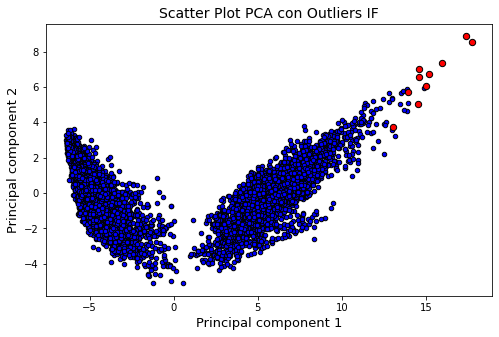

In [83]:
# plot outlier values of IF
plt.figure(figsize=(8,5))
plt.scatter(principal_df[0], principal_df[1], color = "b", s = 20, edgecolor='black')
plt.scatter(outliers_iso_for[0], outliers_iso_for[1], s=40, color = "r", edgecolor='black')
plt.title("Scatter Plot PCA con Outliers IF", fontsize=14)
plt.xlabel("Principal component 1", fontsize=13)
plt.ylabel("Principal component 2", fontsize=13)
plt.show()

In [84]:
#estraggo il subset del KNN per poi plottarlo 
outliers_KNN = principal_df.iloc[index1]

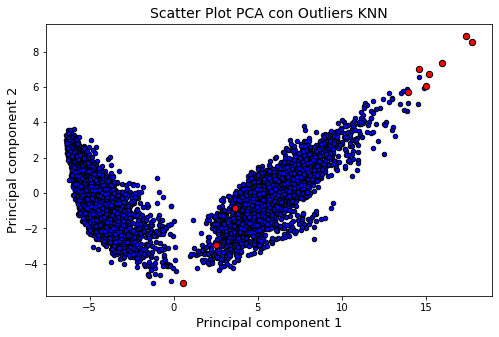

In [85]:
# plot outlier values of KNN
plt.figure(figsize=(8,5))
plt.scatter(principal_df[0], principal_df[1], color = "b", s = 20, edgecolor='black')
plt.scatter(outliers_KNN[0], outliers_KNN[1], s=40, color = "r", edgecolor='black')
plt.title("Scatter Plot PCA con Outliers KNN", fontsize=14)
plt.xlabel("Principal component 1", fontsize=13)
plt.ylabel("Principal component 2", fontsize=13)
plt.show()

In [86]:
#estraggo il subset del ABOD per poi plottarlo 
outliers_ABOD = principal_df.iloc[index2]

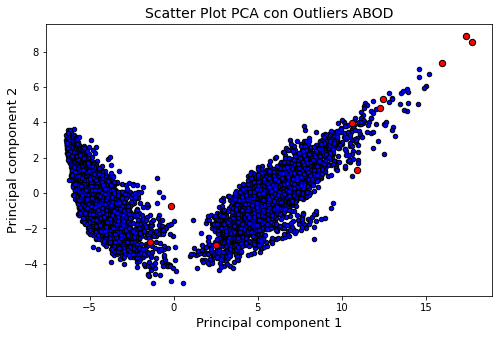

In [87]:
# plot outlier values of ABOD
plt.figure(figsize=(8,5))
plt.scatter(principal_df[0], principal_df[1], color = "b", s = 20, edgecolor='black')
plt.scatter(outliers_ABOD[0], outliers_ABOD[1],s=40, color = "r", edgecolor='black' )
plt.title("Scatter Plot PCA con Outliers ABOD", fontsize=14)
plt.xlabel("Principal component 1", fontsize=13)
plt.ylabel("Principal component 2", fontsize=13)
plt.show()